In [1]:
#Import the relevant packages for simulation

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy
import math
import scipy.interpolate, scipy.integrate, pandas, sys

In [3]:
#Relevant input constants

In [4]:
Epsilon0 = 8.85*10**-14 #free permittivity
q = 1.60*10**-19 #electronic charge
Kb = 1.38*10**-23 #Boltzmann constant
h = 6.63*10**-34 #Planck's constant
c = 3*10**10 #cm/s
Ts = 6000 #Temperature of the sun / K
fs = 1/46050 #Solid angle of sun / Sr

In [5]:
#Input the relevant device parameters

In [6]:
dimensions = [0.5*10**-4,1*10**-4,2*10**-4] #cm
Nc = 4.7*10**17 #Conduction band effective density of states /cm^-3
Nv = 9*10**18 #Valence band effective density of states /cm^-3
Ni = 5*10**16 #Intermediate band density of states /cm^-3
Na = 5*10**16 #Acceptor density in P-region /cm^-3
Nd = 7*10**16 #Donor density in P-region /cm^-3
Ndi = 0 #Donor density in the I-region /cm^-3
EpsilonR = 12.9 #Dielectric constant 
T = 300 #Cell temperature / K
concentration = 1000 #Solar concentrations
taun = 10**-7 #SRH lifetimes (if required)
taup = 10**-7 #SRH lifetimes (if required)
Egap = 1.43*q #Host energy gap (eV)
Eiv = 0.95*q #Intermediate energy gap (eV)

#structure related constants
alpha_ci = 1*10**4 #Absorption coefficients cm^-1
alpha_iv = 1*10**4 #Absorption coefficients cm^-1
alpha_cv = 1*10**4 #Absorption coefficients cm^-1

#calculate the intrinsic carrier concentration
ni = np.sqrt(Nc*Nv)*np.exp(-Egap/(2*Kb*T))

In [7]:
#Define constants that are related to inputs
Epsilon = Epsilon0*EpsilonR #relative permittivity
Etrap = Eiv #Position of trap level = position of intermediate level...
Vthermal = (Kb*T/q) #Thermal voltage 
Vbi = Vthermal*np.log(Na*Nd/ni**2) #Built in =voltage to constrain potential

In [8]:
#define the debeye lengths
Ldn = np.sqrt((Epsilon*Vthermal)/(q*Nd)) #cm
Ldp = np.sqrt((Epsilon*Vthermal)/(q*Na)) #cm
Ldi = np.sqrt((Epsilon*Vthermal)/(q*ni)) #cm

#the mesh spacing must be at least as small as smallest debeye length
dx = Ldn
if dx > Ldp:
    dx = Ldp
    
dx = dx

def roundup(x):
    return int(math.ceil(x / 100.0)) * 100

#the mesh spacing must exceed the value below... 
print('Mesh Number m must exceed:',np.sum(dimensions)/dx)
m=int(roundup(np.sum(dimensions)/dx))
dx = np.sum(dimensions)/m #the mesh spacing determined from mesh number
print('m set to:',m)

Mesh Number m must exceed: 215.51146837420882
m set to: 300


In [9]:
#define the position points of the mesh

In [10]:
points = []
total = np.sum(dimensions)
for i in range(0,m+1):
    points.append(dx*i/Ldi)

#normalize the lengths
dx = dx/Ldi

In [11]:
#set the boundaries of each of the junction regions... 

In [12]:
bound = [0] 
IntermediateNumber = [] 
for i in range(1,len(dimensions)): 
    bound.append((dimensions[i-1]+bound[i-1]))
    
bounds = [] 
for i in bound: 
    bounds.append(i/Ldi)
bounds.append(np.sum(dimensions)/Ldi)

for i in range(0,len(points)):
    if bounds[1]<points[i]<bounds[2]:
        IntermediateNumber.append(i)

In [13]:
#set and normalize the doping levels with the intrinsic concentration
doping = [] 
if len(dimensions) == 2: 
    for i in points: 
        if i <= bounds[1]: 
            doping.append(-Na/ni)
        else: 
            doping.append(Nd/ni)
elif len(dimensions) == 3: 
    for i in points: 
        if i <= bounds[1]: 
            doping.append(-Na/ni)
        elif bounds[1] < i < bounds[2]: 
            doping.append(Ndi/ni)
        else: 
            doping.append(Nd/ni)
else: 
    print('This Simulation Only Runs 2 or 3 Junctions')

In [14]:
#initialise the noramlised potential - this creates an initial guess for the potential
fin = [] 
for i in range(0,len(points)):
    if dx*i < bounds[1]: 
        xx = -np.log(np.abs(Na/ni))
    else: 
        xx= np.log(np.abs(Nd/ni))
    fin.append(xx)

In [15]:
#fi is the fermi function for the intermediate band
def fi(mui,band): 
    return 1/(np.exp(((band-mui))/Vthermal)+1)

#Define a plotting function for the intermediate level
def Intermediate(Potential):
    first = IntermediateNumber[0]
    numbers = [i for i in range(0,len(points))]
    n = [np.exp(i) for i in Potential]
    p = [np.exp(-i) for i in Potential]
    Plotential = [-i*Vthermal for i in Potential]
    Valence = [] 
    Ei = Egap/(2*q)
    for i in Plotential:
        Valence.append(i-min(Plotential))
    Conduction = [i+Egap/q for i in Valence]
    Ei = [] 
    for i in range(0,len(Conduction)):
        Ei.append(Conduction[i]-Egap/(2*q))
    Qfn = [] 
    Qfp = []
    Iband = [] 
    nint = [] 
    for i in range(0,len(n)): 
        Qfn.append((Ei[i]+Kb*T*np.log(n[i])/q))
        Qfp.append((Ei[i]-Kb*T*np.log(p[i])/q))
        if i in IntermediateNumber: 
            Iband.append(Conduction[i]-(Egap-Eiv)/q)
    for i in IntermediateNumber: 
        nint.append((Ni/ni)*fi(Qfn[i],Iband[i-first]))
    Qfi = [Qfn[i] for i in IntermediateNumber]
    return [nint,Conduction,Valence,Iband,Qfn,Qfp,Qfi]

In [16]:
#Equilibrium solution for the potential:
def PotentialEQM(guess):
    change = (Eiv-0.5*Egap)
    numbers = [i for i in range(0,len(points))]
    middle = [] 
    fi = []
    for i in guess:
        fi.append(i)
    #matrix elements
    dx2 = dx**2
    f = np.zeros([len(points),1])
    a = np.zeros([len(points),1])
    b = np.zeros([len(points),1])
    c = np.zeros([len(points),1])
    for i in range(0,len(points)):
        if i in IntermediateNumber:
            f[i] = np.exp(fi[i])+(Ni/ni)*(1/(np.exp(-fi[i]+((Eiv-0.5*Egap)/(q*Vthermal)))+1))-np.exp(-fi[i])-doping[i]-fi[i]*(np.exp(fi[i])+np.exp(-fi[i])+(Ni/ni)*(1/(np.exp(-fi[i]+((Eiv-0.5*Egap)/(q*Vthermal)))+1)))
            a[i] = 1/dx2
            c[i] = 1/dx2
            b[i] = -(2/dx2+np.exp(fi[i])+np.exp(-fi[i])+(Ni/ni)*(1/(np.exp(-fi[i]+((Eiv-0.5*Egap)/(q*Vthermal)))+1)))
        else:
            f[i] = np.exp(fi[i])-np.exp(-fi[i])-doping[i]-fi[i]*(np.exp(fi[i])+np.exp(-fi[i]))
            a[i] = 1/dx2
            c[i] = 1/dx2
            b[i] = -(2/dx2+np.exp(fi[i])+np.exp(-fi[i]))
    #elements at ohmic contacts:
    f[0] = fi[0] 
    f[-1] = fi[-1]
    a[0] = 0
    b[0] = 1
    c[0] = 0
    a[-1] = 0
    b[-1] = 1
    c[-1] = 0
    alpha = np.zeros([len(points),1])
    beta = np.zeros([len(points),1])
    delta = np.zeros([len(points),1])
    vector = np.zeros([len(points),1])
    alpha[0] = b[0]
    for i in range(1,len(points)):
        beta[i] = a[i] / alpha[i-1]
        alpha[i] = b[i] - beta[i]*c[i-1]
    #Lv solution
    vector[0] =  f[0]
    for i in range(1,len(points)):
        vector[i] = f[i] - beta[i]*vector[i-1]
    #Ufi = v
    temp = vector[-1]/alpha[-1]
    delta[-1] = temp - fi[-1]
    fi[-1] = temp
    for i in range(len(points)-2,0,-1):
        temp = (vector[i]-c[i]*temp)/alpha[i]
        delta[i] = temp-fi[i]
        fi[i] = temp
    #calculate and error within the function 
    difference2 = [] 
    maximum = 0
    for i in range(0,len(delta)):
        xx = np.abs(delta[i])
        if xx > maximum: 
            maximum = xx
    outputs = np.zeros([len(points),1])
    for i in range(0,len(fi)): 
        outputs[i,0]=np.float64(fi[i])
    return [outputs,maximum]

#change output to right form on array for later calculations

def iterationEQM(trial):
    #while error > 10**-5: 
    error = 1
    num = 0
    while error > 10**-5: 
        num = num + 1
        if num > 100: 
            print(num)
        new = PotentialEQM(trial)[0]
        trial = new
        error = PotentialEQM(trial)[1]
    return trial

PE = iterationEQM(fin)
NCEQM = np.exp(PE)
PEQM = np.exp(-PE)
NINT = np.full([len(IntermediateNumber),1],(Ni/ni))/(np.exp(-PE[IntermediateNumber[0]-1:IntermediateNumber[-1],:]+np.full([len(IntermediateNumber),1],((Eiv-0.5*Egap)/(q*Vthermal))))+np.full([len(IntermediateNumber),1],1))
#plt.plot(NINT)
#store values in a dataframe... 
data = {'potential':[PE],'econc':[NCEQM],'pconc':[PEQM],'iconc':[NINT]}
plots = {'vband':[Intermediate(PE)[2]],'cband':[Intermediate(PE)[1]],'iband':[Intermediate(PE)[3]],'muC':[Intermediate(PE)[4]],'muV':[Intermediate(PE)[5]],'muI':[Intermediate(PE)[6]]} 
EQMconcs = pandas.DataFrame(data)
EQMenergies = pandas.DataFrame(plots)
filling = [fi(EQMenergies['muI'][0][i],EQMenergies['iband'][0][i])[0] for i in range(0,len(IntermediateNumber))]
EQMoccupation = np.zeros([len(IntermediateNumber),1])
for i in range(0,len(IntermediateNumber)): 
    np.put(EQMoccupation,i,filling[i])

In [17]:
#The non-equilibrium solver for the potential each iteration...

def PotentialNEQM(Potential,n,p,nint,Avoltage):
    fi = []
    for i in Potential:
        fi.append(i)
    fi[0] = fi[0] + Avoltage
    #matrix elements
    dx2 = dx**2
    f = np.zeros([len(points),1])
    a = np.zeros([len(points),1])
    b = np.zeros([len(points),1])
    c = np.zeros([len(points),1])
    for i in range(1,len(points)-1):
        if i in IntermediateNumber:
            f[i] = n[i]+nint[i-IntermediateNumber[0]]-p[i]-doping[i]-fi[i]*(p[i]+nint[i-IntermediateNumber[0]]+n[i])
            a[i] = 1/dx2
            c[i] = 1/dx2
            b[i] = -(2/dx2+p[i]+n[i]+nint[i-IntermediateNumber[0]])
        else:
            f[i] = n[i]-p[i]-doping[i]-fi[i]*(p[i]+n[i])
            a[i] = 1/dx2
            c[i] = 1/dx2
            b[i] = -(2/dx2+p[i]+n[i])
    #elements at ohmic contacts:
    f[0] = fi[0]
    f[-1] = fi[-1]
    a[0] = 0
    b[0] = 1
    c[0] = 0
    a[-1] = 0
    b[-1] = 1
    c[-1] = 0
    alpha = np.zeros([len(points),1])
    beta = np.zeros([len(points),1])
    delta = np.zeros([len(points),1])
    vector = np.zeros([len(points),1])
    alpha[0] = b[0]
    for i in range(1,len(points)):
        beta[i] = a[i] / alpha[i-1]
        alpha[i] = b[i] - beta[i]*c[i-1]
    #Lv solution
    vector[0] =  f[0]
    for i in range(1,len(points)):
        vector[i] = f[i] - beta[i]*vector[i-1]
    #Ufi = v
    temp = vector[-1]/alpha[-1]
    delta[-1] = temp - fi[-1]
    fi[-1] = temp
    for i in range(len(points)-2,0,-1):
        temp = (vector[i]-c[i]*temp)/alpha[i]
        delta[i] = temp-fi[i]
        fi[i] = temp
    #calculate and error within the function 
    maximum = 0
    for i in range(0,len(delta)):
        xx = np.abs(delta[i])
        if xx > maximum: 
            maximum = xx
    outputs = np.zeros([len(points),1])
    for i in range(0,len(fi)): 
        outputs[i,0]=np.float64(fi[i])
    return [outputs,maximum]

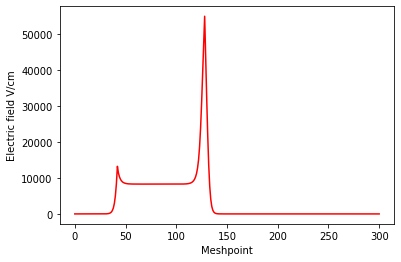

In [18]:
#Calculation the electric field from the potential

def E_field(f):
    efield1 = np.zeros([len(points),1])
    for i in range(1,len(points)-1):
        efield1[i] = np.abs(((f[i]-f[i+1])*(Vthermal/(dx*Ldi))))
    efield1[0] = efield1[1]
    efield1[-1] = efield1[-2]
    return efield1

point = np.array(points)
point = Ldi*10**4*point

ax1 = plt.axes()
ax1.plot(E_field(PE),color='red')
ax1.set_ylabel('Electric field V/cm')
ax1.set_xlabel('Meshpoint')
plt.show()

In [19]:
#The next two cells are for the empirical low field mobility and the field-dependant mobility.

In [20]:
TL = 300 #K
N = Na+Nd #local impurity concentrations

betan = 2
betap = 1

#lowfield mobility inputs:

mumaxn = 9400 
muminn = 500
Nrefn = 6*10**16
lambda1n = 0.394
theta1n = 2.1
theta2n = 3

mumaxp = 491.5 
muminp = 20
Nrefp = 1.48*10**17
lambda1p = 0.38
theta1p = 2.2
theta2p = 3

def Lowfield(N,T):
    a = mumin +((mumax*(1)*(300/T)**theta1)-mumin)/(1+(N/(Nref*1*(T/300)**theta2))**lambda1)
    return a

#The low field mobility values for the both electrons and holes...

mun0 = [(muminn +((mumaxn*(1)*(300/T)**theta1n)-muminn)/(1+(np.abs(i*ni)/(Nrefn*1*(T/300)**theta2n))**lambda1n)) for i in doping]
mup0 = [(muminp +((mumaxp*(1)*(300/T)**theta1p)-muminp)/(1+(np.abs(i*ni)/(Nrefp*1*(T/300)**theta2p))**lambda1p)) for i in doping]

#saturation velocity calculations
vsatn = 10**7
vsatp = 8.37*10**6

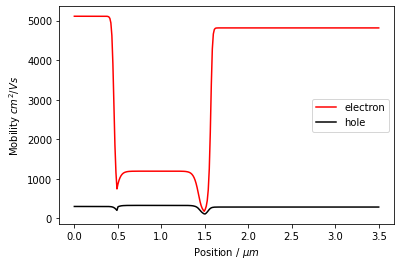

In [21]:
#Calculate the field-dependant mobility...
def fieldmobility(Efield): 
    mup = np.zeros([len(Efield),1])
    mun = np.zeros([len(Efield),1])
    for i in range(0,len(Efield)):
        pdenominator = (mup0[i]*Efield[i]/vsatp)**betap
        mup[i] = mup0[i]*((1/(1+pdenominator))**(1/betap))
        ndenominator = (mun0[i]*Efield[i]/vsatn)**betan
        mun[i] = mun0[i]*((1/(1+ndenominator))**(1/betan))
    return [mun,mup]

point = np.array(points)
point = Ldi*10**4*point
ax = plt.axes()
ax.plot(point,fieldmobility(E_field(PE))[0],color = 'red',label='electron')
ax.plot(point,fieldmobility(E_field(PE))[1],color= 'black',label='hole')
ax.set_ylabel('Mobility $cm^2/Vs$' )
ax.set_xlabel('Position / $\mu m$')
plt.legend(loc = 'center right')

In [22]:
#define functions that switch between the QF levels and the concentrations... 
def Interband(Potential):
    Plotential = -np.full([len(points),1],Vthermal)*Potential
    Valence = Plotential[IntermediateNumber[0]-1:IntermediateNumber[-1],:]-np.full([len(IntermediateNumber),1],min(Plotential))
    Intermediate = Valence+np.full([len(IntermediateNumber),1],Eiv/q)  
    return Intermediate
#looks right... only thing that is off might be the slicing

In [23]:
#Calculating constant generation functions

from scipy.integrate import quad

#functions to speed up term allocations: 
def genint(Elow,Ehigh): 
    constants = ((2*np.pi*concentration*fs)/(h**3*c**2))
    integrand = lambda E: E**2/(np.exp(E/(Kb*Ts))-1)
    integral = quad(integrand,Elow,Ehigh)[0]
    return np.full([len(IntermediateNumber),1],constants*integral)

GCIint = genint(Egap-Eiv,Eiv)
GIVint = genint(Eiv,Egap)

def Recombint(Elow,Ehigh): 
    constants = (2*np.pi/(h**3*c**2))
    integrand = lambda E: E**2*np.exp(-E/(Kb*T))
    integral = quad(integrand,Elow,Ehigh)[0]
    return np.full([len(IntermediateNumber),1],constants*integral)

RCIint = Recombint(Egap-Eiv,Eiv)
RIVint = Recombint(Eiv,Egap)

In [24]:
#A series of functions that make it easier to parallel process each of the meshpoints within the intermediate band... 

def mexponent(x):
    return np.exp(-x)

def cumulativeoccupation(occupation):
    cumulative = np.zeros([len(IntermediateNumber),1])
    for i in range(0,len(occupation)): 
        cumulative[i,0] = np.sum(occupation[0:i,:])
    return cumulative

def absorptionterm(alpha,cumulativeoccupation): 
    return alpha*np.apply_along_axis(mexponent,0,cumulativeoccupation*dx*Ldi*alpha)

In [25]:
# Define the relevant generation and recombination terms for the intermediate band

def GCI(occupation):
    occ = occupation.reshape([len(IntermediateNumber),1])
    cumulativeocc = cumulativeoccupation(occ)
    absorb = absorptionterm(alpha_ci,cumulativeocc)
    absorption = occ*absorb
    ret = absorption*GCIint
    return ret.reshape([len(IntermediateNumber),])

def GIV(occupation):
    occ = occupation.reshape([len(IntermediateNumber),1])
    cumulativeocc = cumulativeoccupation(occ)
    absorb = absorptionterm(alpha_iv,cumulativeocc)
    absorption = (np.full([len(IntermediateNumber),1],1)-occ)*absorb
    ret = absorption*GIVint
    return ret.reshape([len(IntermediateNumber),])

def RCI(Potential,muC,occupation):
    occ = occupation.reshape([len(IntermediateNumber),1])
    muI = Interband(Potential) - np.full([len(IntermediateNumber),1],Vthermal)*np.log((np.full([len(IntermediateNumber),1],1)-occ)/occ)
    absorption = np.full([len(IntermediateNumber),1],alpha_ci)
    splitting = (np.exp((muC[IntermediateNumber[0]-1:IntermediateNumber[-1],:]-muI)/np.full([len(IntermediateNumber),1],Vthermal))-np.full([len(IntermediateNumber),1],1))
    ret = absorption*RCIint*splitting
    return ret.reshape([len(IntermediateNumber),])

def RIV(Potential,muV,occupation):
    occ = occupation.reshape([len(IntermediateNumber),1])
    muI = Interband(Potential) - np.full([len(IntermediateNumber),1],Vthermal)*np.log((np.full([len(IntermediateNumber),1],1)-occ)/occ)
    absorption = np.full([len(IntermediateNumber),1],alpha_iv)
    splitting = np.exp((muI-muV[IntermediateNumber[0]-1:IntermediateNumber[-1]:])/np.full([len(IntermediateNumber),1],Vthermal))-np.full([len(IntermediateNumber),1],1)
    ret = absorption*RIVint*splitting
    return ret.reshape([len(IntermediateNumber),])

#recomb terms havent been verified yet

In [26]:
def MUI(Potential,occ):
    Occupation = occ.reshape([len(IntermediateNumber),1])
    InB = Interband(Potential)
    occterm = Vthermal*np.log((np.full([len(IntermediateNumber),1],1)-Occupation)/Occupation)
    return InB - occterm

In [27]:
#The intermediate band solver... calculated the position of the intermediate band at all points simultaneously...

from scipy.optimize import root

def IntermediateSolve(Potential,Qfn,Qfp): 
    tosolve = lambda occupy: GIV(occupy)-GCI(occupy)+RCI(Potential,Qfn,occupy)-RIV(Potential,Qfp,occupy)
    inter = scipy.optimize.root(tosolve,np.full([len(IntermediateNumber),1],0.1),tol = 10**-11)['x']
    newocc = inter.reshape([len(IntermediateNumber),1])
    netgen = GCI(inter)-RCI(Potential,Qfn,inter)
    QFlevel = MUI(Potential,inter)
    return [QFlevel,newocc,netgen]

In [28]:
def trialgen(Potential,muC,muV,occupation):
    return -GCI(occupation)+GIV(occupation)+RCI(Potential,muC,occupation)-RIV(Potential,muV,occupation)

In [29]:
from scipy.interpolate import interp1d
from scipy.integrate import quad

def fi(mui,band): 
    return 1/(np.exp(((band-mui))/Vthermal)+1)

#if fi is a list, it makes it easy to calculate an interpolation of this function...

def GCV(point): 
    distance = point*dx*Ldi
    constants = ((2*np.pi*concentration*fs)/(h**3*c**2))
    absorption = alpha_cv*np.exp(-alpha_cv*distance)
    integrand = lambda E: E**2/(np.exp(E/(Kb*Ts))-1)
    integral = quad(integrand,Egap,12*q)[0]
    return constants*absorption*integral

#note these functions are made purely for the solver and will have to be redefined for 0 points. muI is the only point not list

def RCV(point,n,p):
    constants = (2*np.pi/(h**3*c**2*ni**2))
    absorption = alpha_cv*np.exp(-alpha_cv*dx*Ldi*point)
    integrand = lambda E: E**2*np.exp(-E/(Kb*T))
    integral = quad(integrand,Egap,10*q)[0]
    return constants*absorption*integral*(n[point]*p[point]*ni**2-ni**2)

def inputpower(): 
    constants = ((2*np.pi*fs*concentration)/(h**3*c**2))
    integrand = lambda E: E*(E**2/(np.exp(E/(Kb*Ts))-1))
    integral = scipy.integrate.quad(integrand,0,11*q)[0]
    return constants*integral

print(inputpower())

158.7801773071696


In [30]:
#A function that calculates the quasi fermi levels within the device

from scipy.optimize import fsolve

def QFL(Potential,n,p):
    n1 = n.reshape([len(points),1])
    p1 = p.reshape([len(points),1])
    Plotential = -Potential*np.full([len(points),1],Vthermal) #[-i*Vthermal for i in Potential]
    Valence = Plotential-np.full([len(points),1],min(Plotential))
    Conduction = Valence + np.full([len(points),1],Egap/q)
    Qfn = Conduction+Kb*T*np.log((n1*np.full([len(points),1],ni)/np.full([len(points),1],Nc)))/q
    Qfp = Valence-Kb*T*np.log((p1*np.full([len(points),1],ni)/np.full([len(points),1],Nv)))/q
    return [Qfn,Qfp]

#QFL now only returns the first two... 

In [31]:
#A computational form of the Bernoulli function

def Bernoulli(x):
    bol = False
    if x > 0.01:
        return x*np.exp(-x)/(1-np.exp(-x))
    elif x < 0 and np.abs(x) > 0.01:
        return x/(np.exp(x)-1)
    elif x == 0:
        return 1
    else:
        term = 1
        sum = term
        i = 0
        while bol == False:
            i = i + 1
            term =term*x/float(i+1)
            if (sum + term) == sum:
                bol = True
            sum = sum + term
        return 1/sum

In [32]:
#Functions that determine the electron and hole concentrations within the device...

def econc(Potential,n,p,newgen):
    mun = fieldmobility(E_field(Potential))[0]
    f = np.zeros([len(points),1])
    a = np.zeros([len(points),1])
    b = np.zeros([len(points),1])
    c = np.zeros([len(points),1])
    #elements at ohmic contacts:
    a[0] = 0
    b[0] = 1
    c[0] = 0
    f[0] = n[0]
    a[-1] = 0
    b[-1] = 1
    c[-1] = 0
    f[-1] = n[-1]
    for i in range(1,len(points)-1):
        muminus = (mun[i-1]+mun[i])/2
        muplus = (mun[i]+mun[i+1])/2
        a[i] = muminus*Bernoulli(Potential[i-1]-Potential[i])
        b[i] = -(muminus*Bernoulli(Potential[i]-Potential[i-1])+muplus*Bernoulli(Potential[i]-Potential[i+1]))
        c[i] = muplus*Bernoulli(Potential[i+1]-Potential[i])
        if i in IntermediateNumber: 
            f[i] = (Ldi**2*dx**2/Vthermal)*(RCV(i,n,p)/ni-GCV(i)/ni-newgen[i-IntermediateNumber[0]]/ni)
        else: 
            f[i] = (Ldi**2*dx**2/Vthermal)*(RCV(i,n,p)/ni-GCV(i)/ni)
    alpha = np.zeros([len(points),1])
    beta = np.zeros([len(points),1])
    delta = np.zeros([len(points),1])
    vector = np.zeros([len(points),1])
    alpha[0] = b[0]
    for i in range(1,len(points)):
        beta[i] = a[i]/alpha[i-1]
        alpha[i] = b[i]-beta[i]*c[i-1]
    vector[0] = f[0]
    for i in range(1,len(points)):
        vector[i] = f[i] - beta[i]*vector[i-1]
    temp = vector[-1]/alpha[-1]
    n[-1] = temp
    for i in range(len(points)-2,0,-1):
        temp = (vector[i]-c[i]*temp)/alpha[i]
        n[i] = temp
    n = np.array(n)
    return n

def pconc(Potential,n,p,newgen):
    mup = fieldmobility(E_field(Potential))[1]
    f = np.zeros([len(points),1])
    a = np.zeros([len(points),1])
    b = np.zeros([len(points),1])
    c = np.zeros([len(points),1])
    #elements at ohmic contacts:
    a[0] = 0
    b[0] = 1
    c[0] = 0
    f[0] = p[0]
    a[-1] = 0
    b[-1] = 1
    c[-1] = 0
    f[-1] = p[-1]
    for i in range(1,len(points)-1):
        muminus = (mup[i-1]+mup[i])/2
        muplus = (mup[i]+mup[i+1])/2
        a[i] = muminus*Bernoulli(Potential[i]-Potential[i-1])
        b[i] = -(muminus*Bernoulli(Potential[i-1]-Potential[i])+muplus*Bernoulli(Potential[i+1]-Potential[i]))
        c[i] = muplus*Bernoulli(Potential[i]-Potential[i+1])
        if i in IntermediateNumber: 
            f[i] = (Ldi**2*dx**2/Vthermal)*(RCV(i,n,p)/ni-GCV(i)/ni-newgen[i-IntermediateNumber[0]]/ni)#-GCI(i)/ni)
        else: 
            f[i] = (Ldi**2*dx**2/Vthermal)*(RCV(i,n,p)/ni-GCV(i)/ni) #(p[i]*n[i]-1)/(taup*(n[i]+1)+taun*(p[i]+1))+
    alpha = np.zeros([len(points),1])
    beta = np.zeros([len(points),1])
    delta = np.zeros([len(points),1])
    vector = np.zeros([len(points),1])
    alpha[0] = b[0]
    for i in range(1,len(points)):
        beta[i] = a[i]/alpha[i-1]
        alpha[i] = b[i]-beta[i]*c[i-1]
    vector[0] = f[0]
    for i in range(1,len(points)):
        vector[i] = f[i] - beta[i]*vector[i-1]
    temp = vector[-1]/alpha[-1]
    p[-1] = temp
    for i in range(len(points)-2,0,-1):
        temp = (vector[i]-c[i]*temp)/alpha[i]
        p[i] = temp
    p = np.array(p)
    return p

In [33]:
#A function that determines the position of each of the energy bands

def JunctionPlots(Potential,n,p):
    Plotential = -np.full([len(points),1],Vthermal)*Potential
    Valence = Plotential - np.full([len(points),1],min(Plotential))
    Conduction = Valence + np.full([len(points),1],Egap/q)
    Intermediate = Valence + np.full([len(points),1],Eiv/q)
    Intermediate = Intermediate[IntermediateNumber[0]-1:IntermediateNumber[-1],:]
    return [Conduction,Valence,Intermediate]

In [34]:
#A function that calculates the electron and hole currents from the potential and concentrations...

def Current(Potential,n,p):
    mobilitye = fieldmobility(E_field(Potential))[0]
    mobilityp = fieldmobility(E_field(Potential))[1]
    J = []
    J1 = []
    J2 = [] 
    for i in range(1,len(points)-1):
        muminus = (mobilitye[i-1]+mobilitye[i])/2
        muplus = (mobilitye[i]+mobilitye[i+1])/2
        muminusp = (mobilityp[i-1]+mobilityp[i])/2
        muplusp = (mobilityp[i]+mobilityp[i+1])/2
        Je1 = ((q*muminus*Vthermal*ni)/(dx*Ldi))*(n[i]*Bernoulli(Potential[i]-Potential[i-1])-n[i-1]*Bernoulli(Potential[i-1]-Potential[i]))
        Je2 = ((q*muplus*Vthermal*ni)/(dx*Ldi))*(n[i+1]*Bernoulli(Potential[i+1]-Potential[i])-n[i]*Bernoulli(Potential[i]-Potential[i+1]))
        Jp1 = ((q*muminusp*Vthermal*ni)/(dx*Ldi))*(p[i]*Bernoulli(Potential[i-1]-Potential[i])-p[i-1]*Bernoulli(Potential[i]-Potential[i-1]))
        Jp2 = ((q*muplusp*Vthermal*ni)/(dx*Ldi))*(p[i+1]*Bernoulli(Potential[i]-Potential[i+1])-p[i]*Bernoulli(Potential[i+1]-Potential[i]))
        Jelec = -(0.5*(Je1+Je2))
        Jhole = (0.5*(Jp1+Jp2))
        J1.append(Jelec)
        J2.append(Jhole)
        J.append(Jelec+Jhole)
    return J[0]

In [35]:
def JunctionPlots(Potential,n,p):
    Plotential = -np.full([len(points),1],Vthermal)*Potential
    Valence = Plotential - np.full([len(points),1],min(Plotential))
    Conduction = Valence + np.full([len(points),1],Egap/q)
    Intermediate = Valence + np.full([len(points),1],Eiv/q)
    return [Conduction,Valence,Intermediate[IntermediateNumber[0]-1:IntermediateNumber[-1],:]]

In [36]:
from scipy.interpolate import interp1d
from scipy.optimize import fminbound

def MPP(Voltage,Current):
    interp = scipy.interpolate.interp1d(Voltage,Current)
    power = lambda V: -V*interp(V)
    volt = fminbound(power,0,max(Voltage))
    eff = (volt*interp(volt)/inputpower())*100
    return [volt,volt*interp(volt),eff]

In [37]:
def intermediateconc(Potential,Qfi): 
    Plotential = [-i*Vthermal for i in Potential]
    Valence = [] 
    Ei = Egap/(2*q)
    for i in Plotential:
        Valence.append(i-min(Plotential))
    Ei = [] 
    for i in range(0,len(Plotential)):
        Ei.append(Valence[i]+Egap/(2*q))
    Intermediate = [] 
    for i in IntermediateNumber: 
        Intermediate.append(Valence[i]+Eiv/q)  
    iconc = [] 
    for i in range(0,len(IntermediateNumber)):
        filling = 1/(np.exp((Intermediate[i]-Qfi[i])/(Vthermal))+1)
        iconc.append((Ni/ni)*filling)
    return iconc

In [38]:
def fi(mui,band): 
    return 1/(np.exp(((band-mui))/Vthermal)+1)

In [39]:
xvals = [i*Ldi*10**4 for i in points]
intxvals = [i*Ldi*10**4*dx for i in IntermediateNumber]

0.0


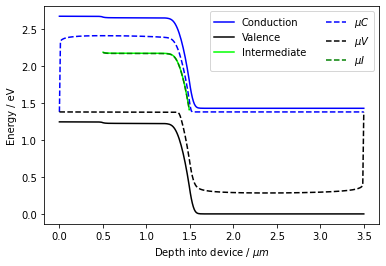

0.008609271523178808


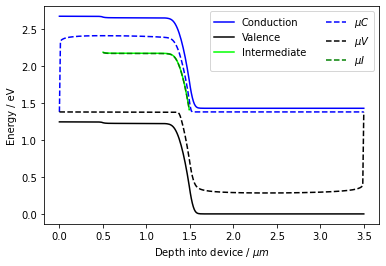

0.017218543046357615


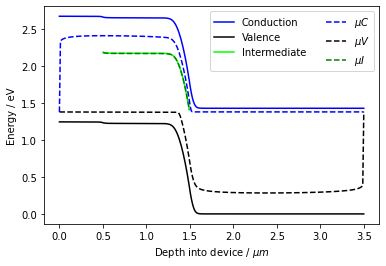

0.025827814569536423


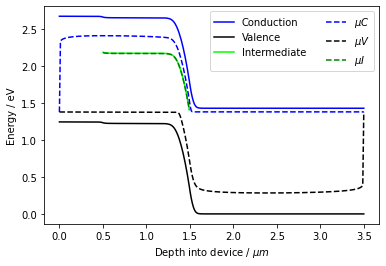

0.03443708609271523


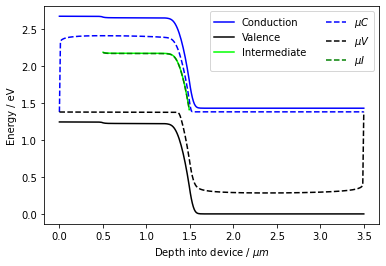

0.04304635761589404


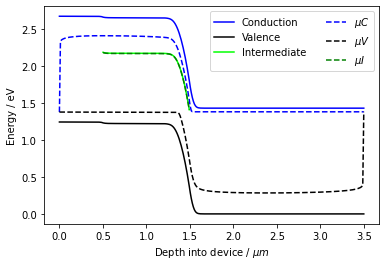

0.051655629139072845


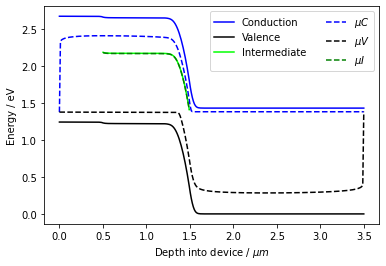

0.06026490066225165


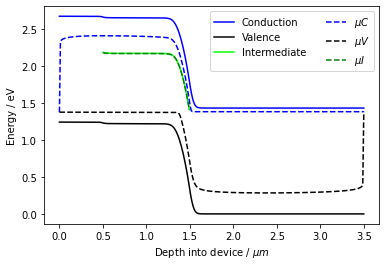

0.06887417218543046


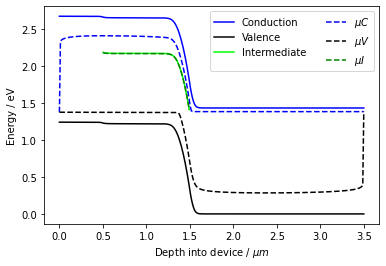

0.07748344370860927


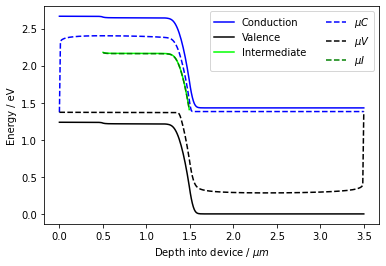

0.08609271523178808


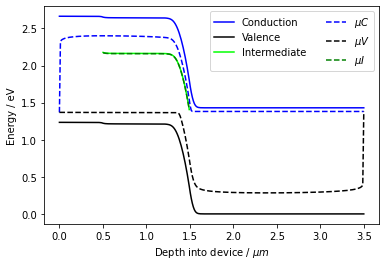

0.09470198675496688


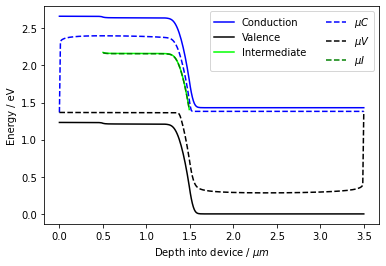

0.10331125827814569


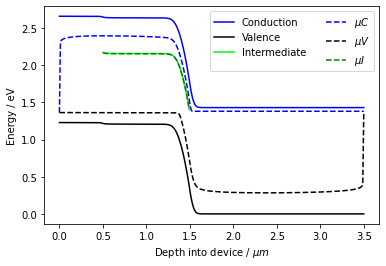

0.1119205298013245


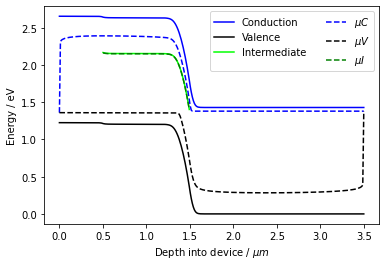

0.1205298013245033


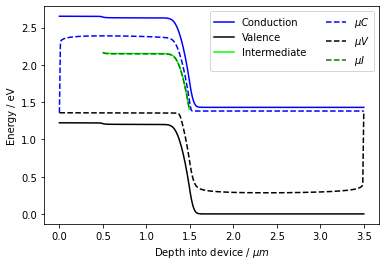

0.1291390728476821


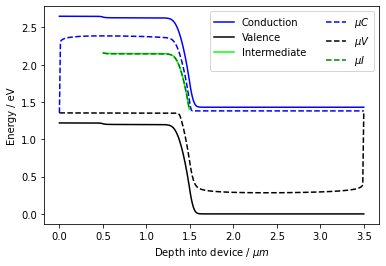

0.13774834437086092


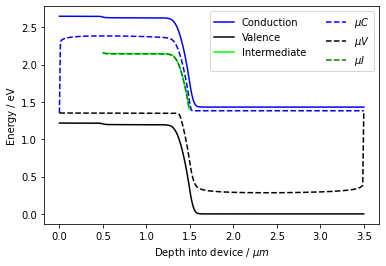

0.14635761589403973


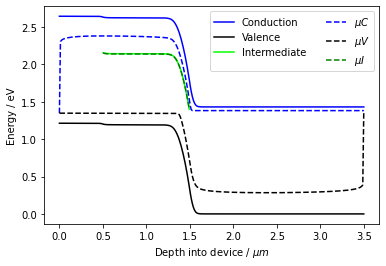

0.15496688741721854


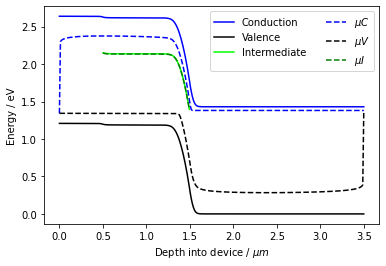

0.16357615894039734


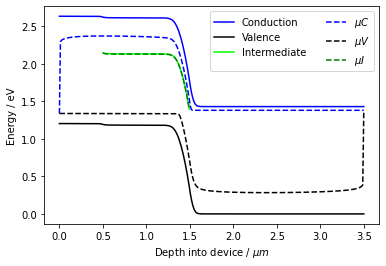

0.17218543046357615


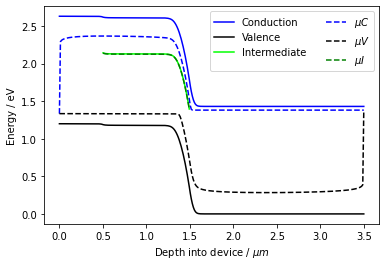

0.18079470198675496


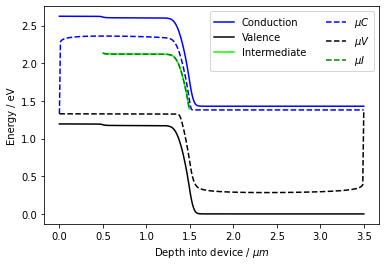

0.18940397350993377


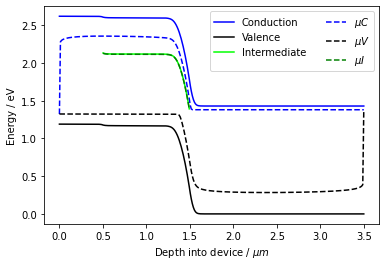

0.19801324503311257


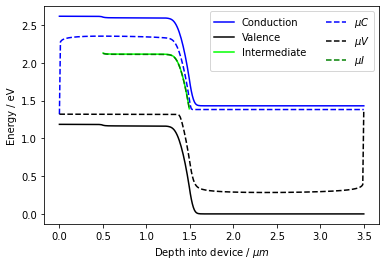

0.20662251655629138


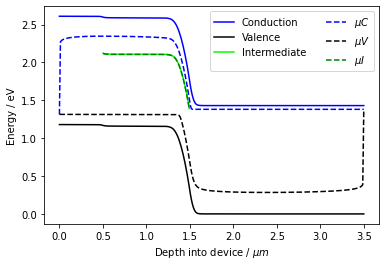

0.2152317880794702


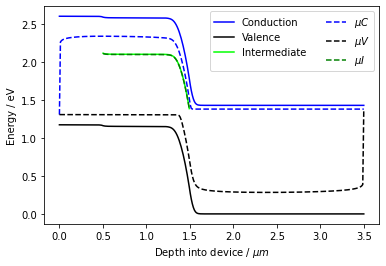

0.223841059602649


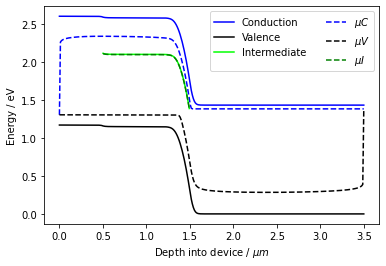

0.2324503311258278


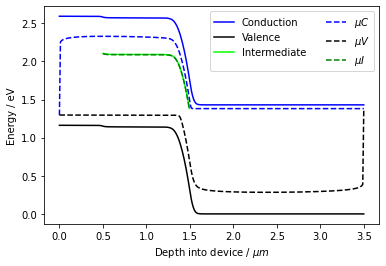

0.2410596026490066


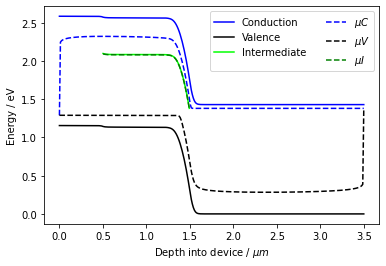

0.24966887417218542


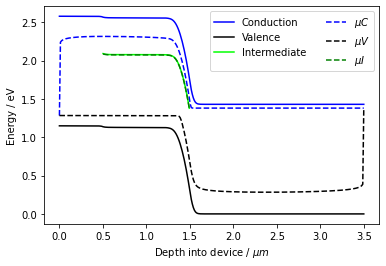

0.2582781456953642


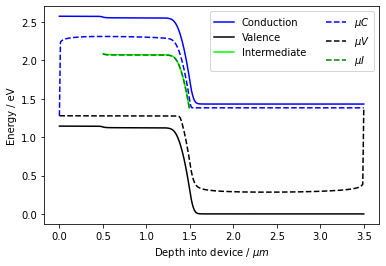

0.26688741721854303


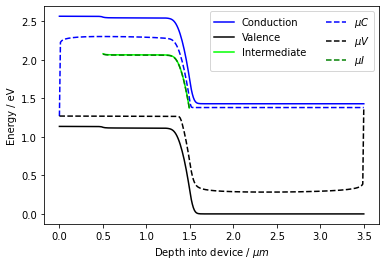

0.27549668874172184


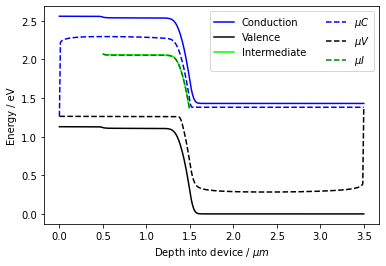

0.28410596026490065


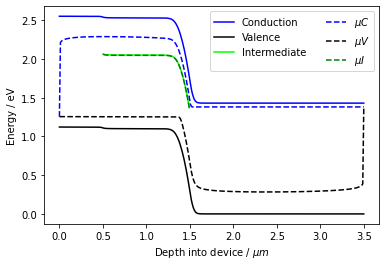

0.29271523178807946


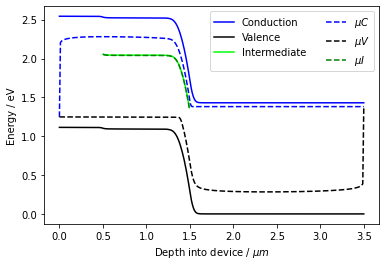

0.30132450331125826


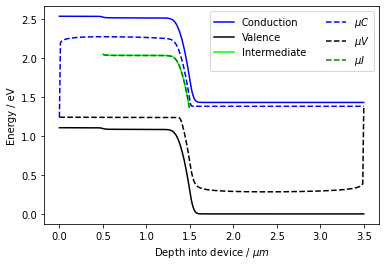

0.30993377483443707


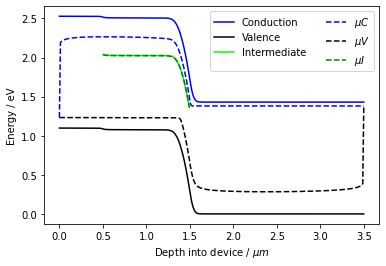

0.3185430463576159


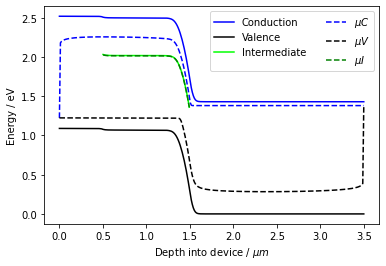

0.3271523178807947


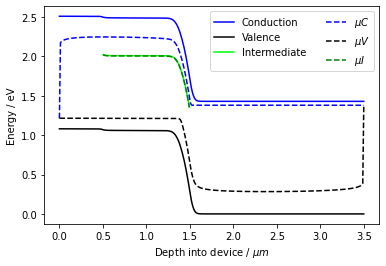

0.3357615894039735


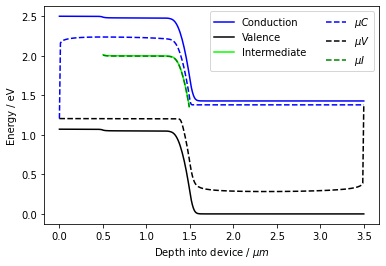

0.3443708609271523


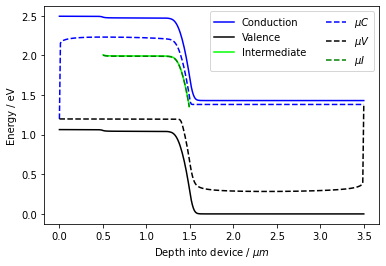

0.3529801324503311


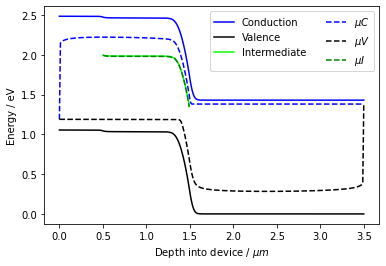

0.3615894039735099


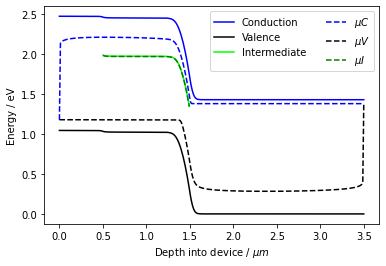

0.3701986754966887


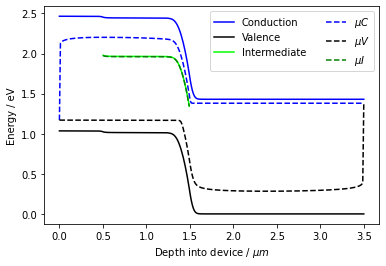

0.37880794701986753


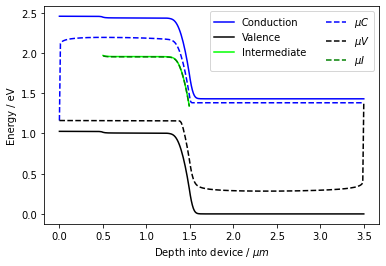

0.38741721854304634


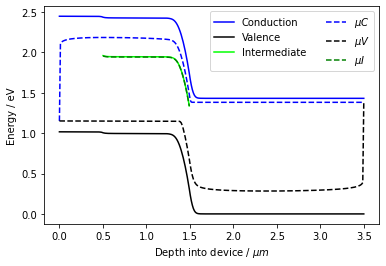

0.39602649006622515


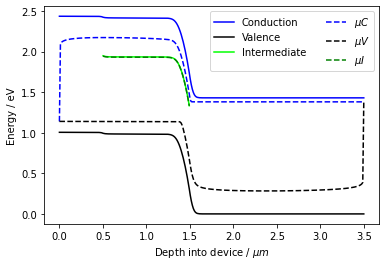

0.40463576158940395


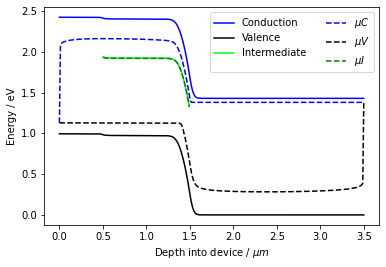

0.41324503311258276


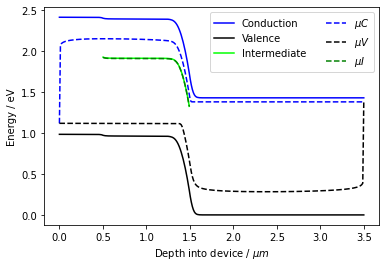

0.42185430463576157


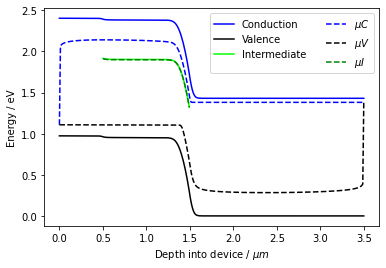

0.4304635761589404


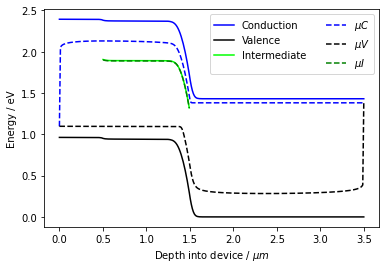

0.4390728476821192


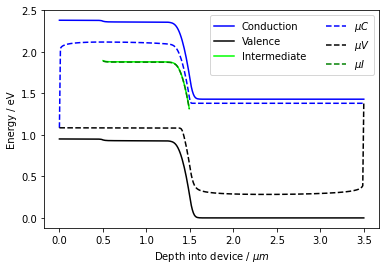

0.447682119205298


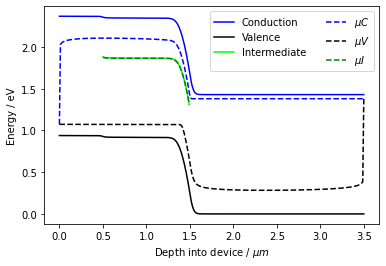

0.4562913907284768


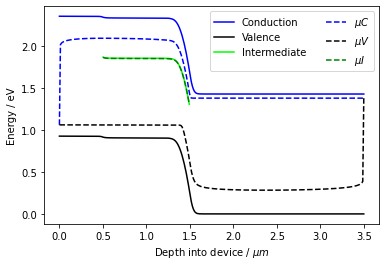

0.4649006622516556


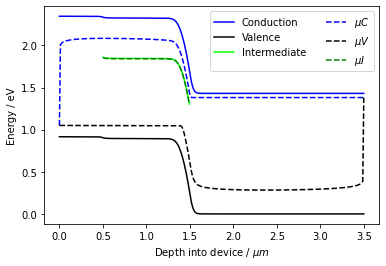

0.4735099337748344


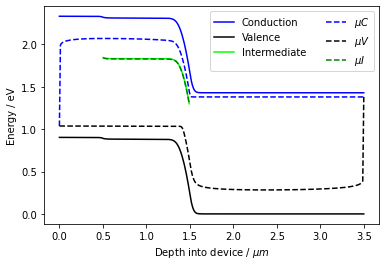

0.4821192052980132


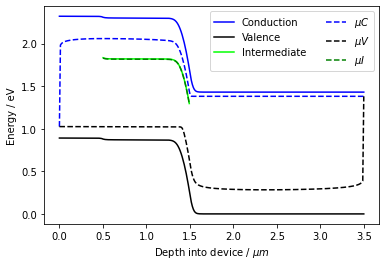

0.49072847682119203


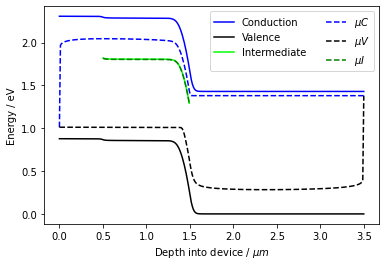

0.49933774834437084


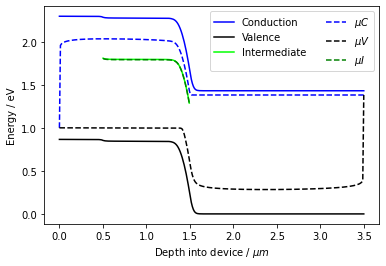

0.5079470198675496


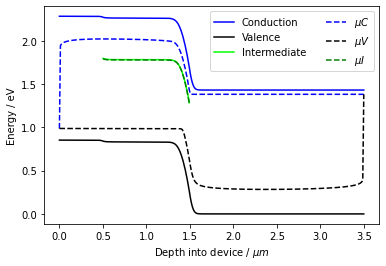

0.5165562913907285


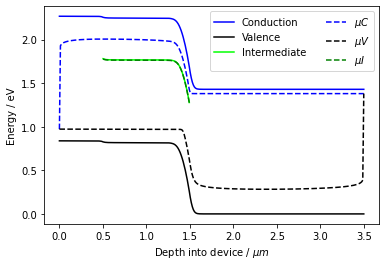

0.5251655629139073


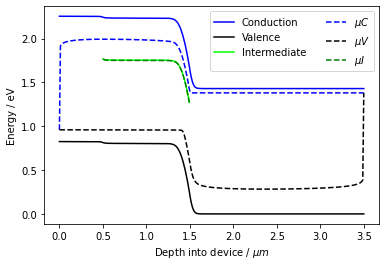

0.5337748344370861


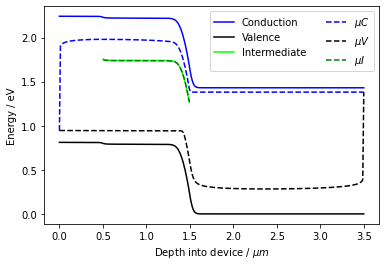

0.5423841059602649


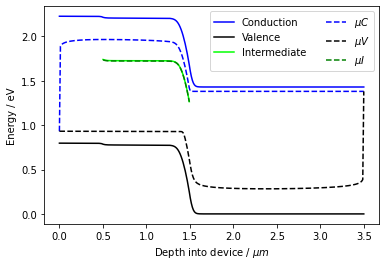

0.5509933774834437


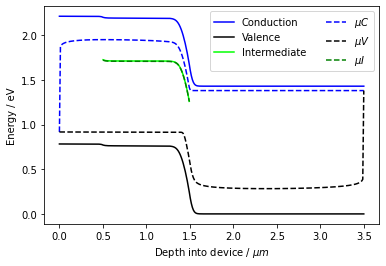

0.5596026490066225


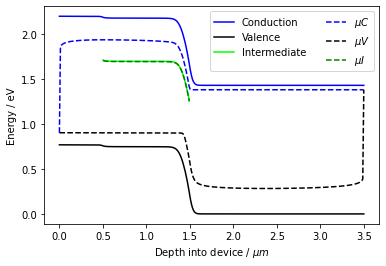

0.5682119205298013


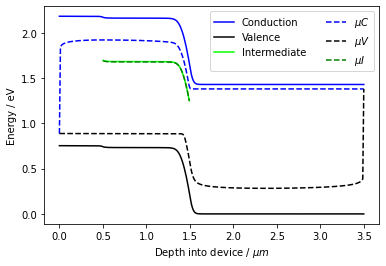

0.5768211920529801


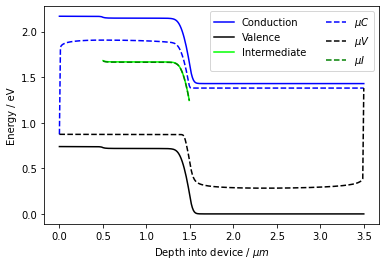

0.5854304635761589


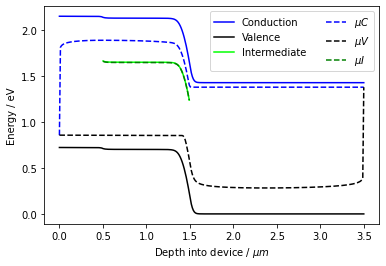

0.5940397350993377


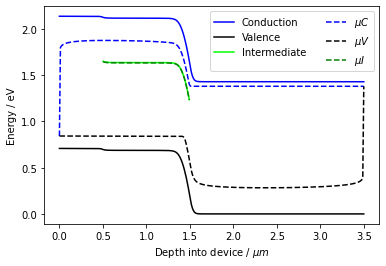

0.6026490066225165


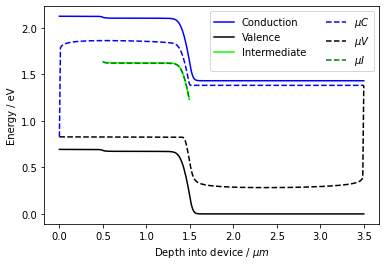

0.6112582781456953


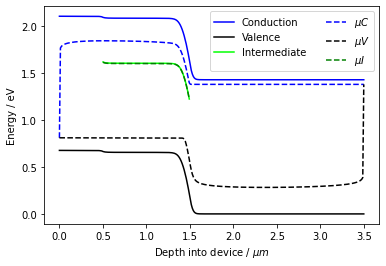

0.6198675496688741


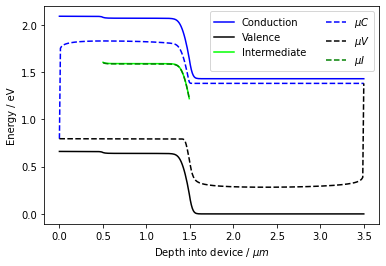

0.628476821192053


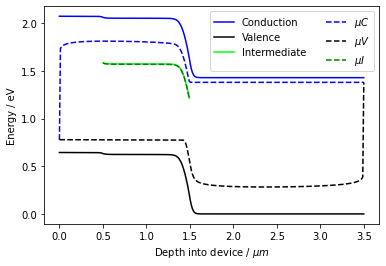

0.6370860927152318


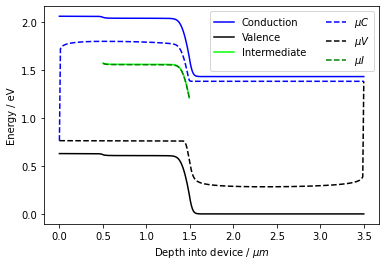

0.6456953642384106


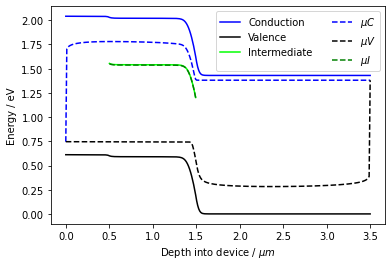

0.6543046357615894


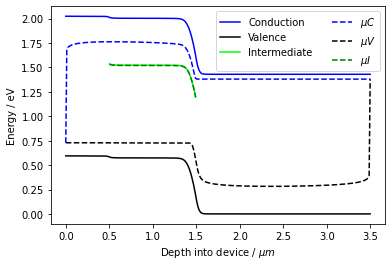

0.6629139072847682


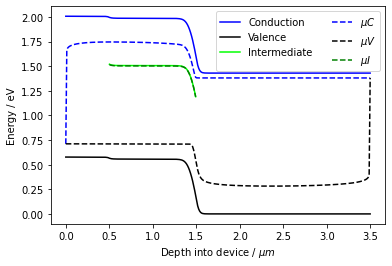

0.671523178807947


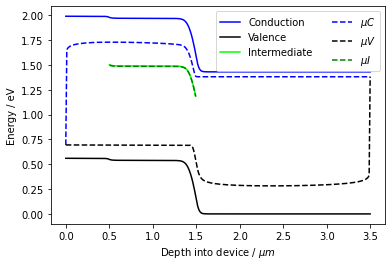

0.6801324503311258


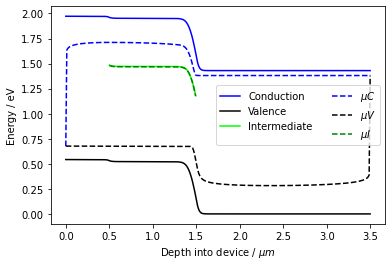

0.6887417218543046


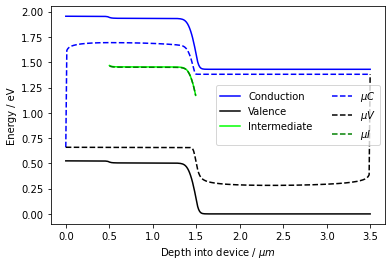

0.6973509933774834


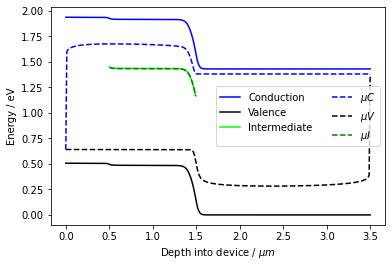

0.7059602649006622


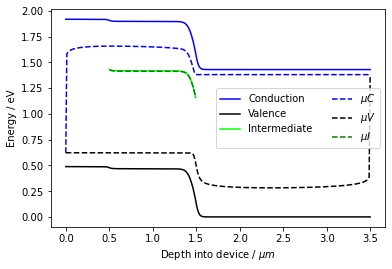

0.714569536423841


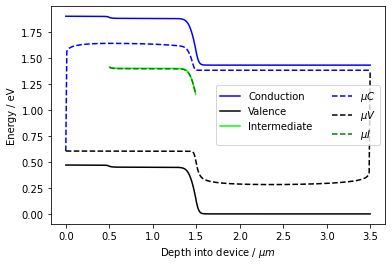

0.7231788079470198


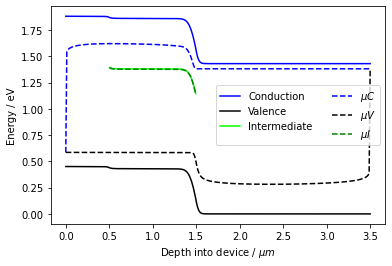

0.7317880794701986


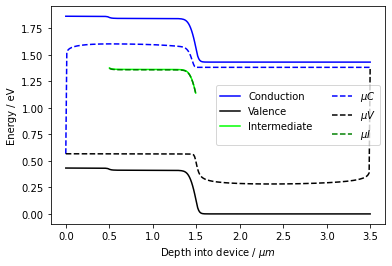

0.7403973509933774


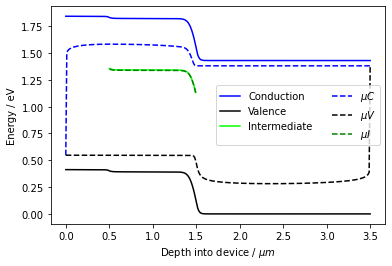

0.7490066225165563


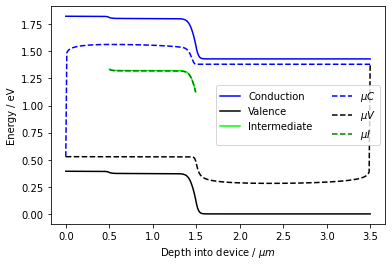

0.7576158940397351


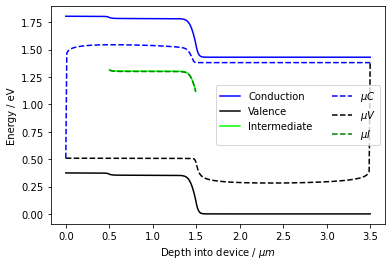

0.7662251655629139


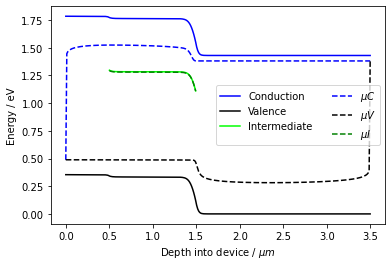

0.7748344370860927


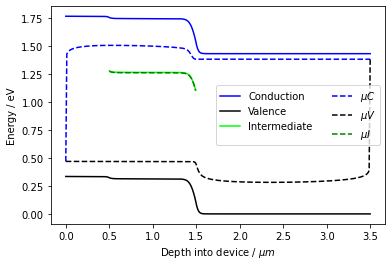

0.7834437086092715


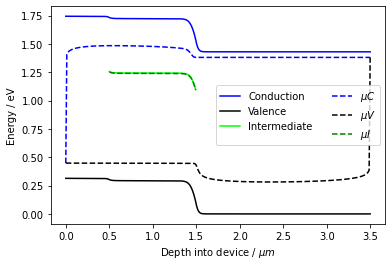

0.7920529801324503


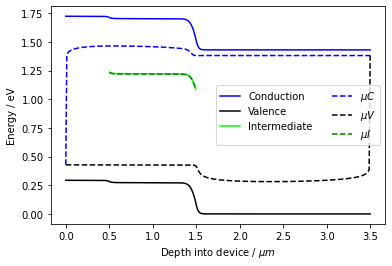

0.8006622516556291


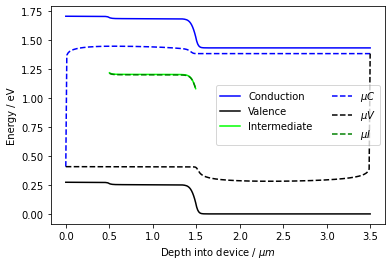

0.8092715231788079


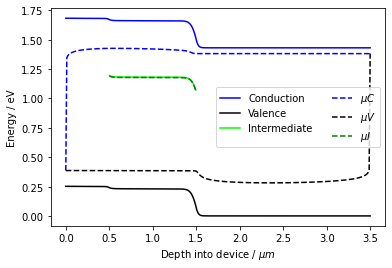

0.8178807947019867


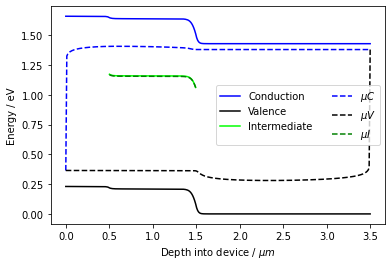

0.8264900662251655


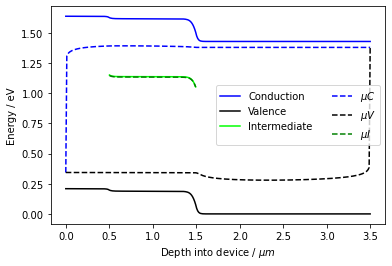

0.8350993377483443


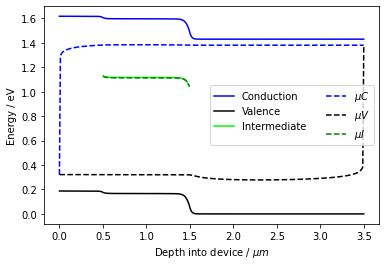

0.8437086092715231


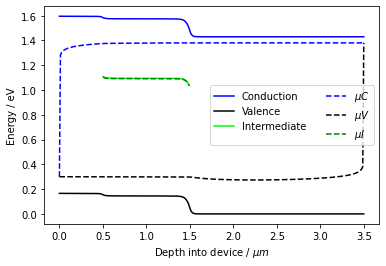

0.8523178807947019
Current switching signs -- break


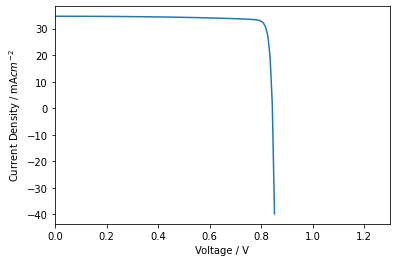

In [40]:
V = 1.3#initialise the noramlised potential
steps = np.linspace(0,V,int(V/(Vthermal*0.33)))
steps = list(steps)
if len(steps) == 0: 
    steps = [0]
    
import pandas as pd

def NewIteration(): 
    tocollect = {'Voltage':[],'Current':[],'Concentration':[],'Suns':[]}
    dffinal = pd.DataFrame(tocollect)
    EQMP = (iterationEQM(fin))
    NCEQM = np.exp(EQMP)
    PEQM = np.exp(-EQMP)
    NINT = np.full([len(IntermediateNumber),1],(Ni/ni))/(np.exp(-EQMP[IntermediateNumber[0]-1:IntermediateNumber[-1],:]+np.full([len(IntermediateNumber),1],((Eiv-0.5*Egap)/(q*Vthermal))))+np.full([len(IntermediateNumber),1],1))
    data = {'potential':[PE],'econc':[NCEQM],'pconc':[PEQM],'iconc':[NINT]}
    df = pandas.DataFrame(data)
    energy = {'vband':[Intermediate(EQMP)[2]],'cband':[Intermediate(EQMP)[1]],'iband':[Intermediate(EQMP)[3]],'muC':[Intermediate(EQMP)[4]],'muV':[Intermediate(EQMP)[5]],'muI':[Intermediate(EQMP)[6]]} 
    energies = pandas.DataFrame(energy)
    standard = 10**-5
    error = 1 
    position = 0
    Voltages = [] 
    Currents = [] 
    newgen = [0 for i in IntermediateNumber] 
    for i in steps:
        print(i)
        error = 1
        Voltages.append(i)
        volt = i
        iteration = 0
        while (error > standard):
            iteration = iteration+1
            if iteration > 1000: 
                print('exceeded iteration limit')
                break
            enew = econc(df['potential'][0],df['econc'][0],df['pconc'][0],newgen)
            pnew = pconc(df['potential'][0],df['econc'][0],df['pconc'][0],newgen)
            df['econc'] = [enew]
            df['pconc'] = [pnew]
            Qflevels = QFL(df['potential'][0],df['econc'][0],df['pconc'][0])
            energies['muC'] = [Qflevels[0]]
            energies['muV'] = [Qflevels[1]]
            ivals = IntermediateSolve(df['potential'][0],energies['muC'][0],energies['muV'][0])
            energies['muI'] = [ivals[0]]
            for i in range(0,len(IntermediateNumber)): 
                inew = [i*(Ni/ni) for i in ivals[1]]
            df['iconc'] = [inew]
            updatedpotential = PotentialNEQM(df['potential'][0],df['econc'][0],df['pconc'][0],df['iconc'][0],volt)
            df['potential'] = [updatedpotential[0]]
            Jn = JunctionPlots(df['potential'][0],df['econc'][0],df['pconc'][0])
            energies['cband'] = [Jn[0]]
            energies['vband'] = [Jn[1]]
            energies['iband'] = [Jn[2]]
            newgen = [] 
            for i in range(0,len(IntermediateNumber)): 
                newgen.append(ivals[2][i])
            if position >= len(steps)-1:
                position = len(steps)-1
            else: 
                position = position + 1
            tryal = ivals[1]
            error = updatedpotential[1] 
            volt = 0
        Currentout = Current(df['potential'][0],df['econc'][0],df['pconc'][0])
        if Currentout < 0: 
            print('Current switching signs -- break')
            Currents.append(float(Currentout[-1])/concentration)
            break
        if volt == 0: 
            plt.plot(xvals,energies['cband'][0],color='blue',label='Conduction')
            plt.plot(xvals,energies['vband'][0],color='black',label='Valence')
            plt.plot(intxvals,energies['iband'][0],color='lime',label='Intermediate')
            plt.plot(xvals,energies['muC'][0],linestyle='dashed',color='blue',label = '$\mu C$')
            plt.plot(xvals,energies['muV'][0],linestyle='dashed',color='black',label = '$\mu V$')
            plt.plot(intxvals,energies['muI'][0],linestyle='--',color='green',label = '$\mu I$')
            plt.xlabel('Depth into device / $\mu m$')
            plt.ylabel('Energy / eV')
            plt.legend(ncol=2)
            plt.show()
        Currents.append(float(Currentout[-1])/concentration)
    newadd = {'Voltage':Voltages,'Current':Currents,'Concentration':[Ndi],'Suns':[concentration]}
    dffinal = dffinal.append(newadd,ignore_index=True)
    dffinal.to_csv('1000concnofill.txt')
    plt.plot(steps[0:len([i*10**3 for i in Currents])],[i*10**3 for i in Currents])
    plt.xlabel('Voltage / V')
    plt.ylabel('Current Density / mA$cm^{-2}$')
    plt.xlim([0,max(steps)])
    plt.show()
    return 
   
NewIteration()


In [41]:
#after investigations, plot in this cell. 